In [20]:
import optuna
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [21]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/All/overlap_All(1%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/All/overlap_All(1%)_test.csv")

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# Down Sampling
# train 데이터의 레이블 비율 확인
train_labels = train_data['y']
label_counts = train_labels.value_counts()

# train 데이터의 레이블 비율이 1:1이 되도록 분할
class_0_data = train_data[train_data['y'] == 0]
class_1_data = train_data[train_data['y'] == 1]

# 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
num_samples = min(label_counts[0], label_counts[1])
class_0_data = class_0_data.sample(num_samples, random_state=42)

# 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_1_data = class_1_data.sample(num_samples, random_state=42)

# 선택한 데이터를 결합하여 최종 train 데이터 생성
train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (3442, 55) 

train shape
 (146, 55) 

train value
 0    1721
1    1721
Name: y, dtype: int64
test value
 0    117
1     29
Name: y, dtype: int64


In [22]:
# Objective 함수 정의
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_split = trial.suggest_float("min_samples_split", 0.1, 1.0)
    min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.1, 0.5)
    
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Cross Validation을 활용한 평가 지표 계산
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return scores.mean()

# Optuna를 활용한 Hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 최적의 Hyperparameter로 모델 학습
best_params = study.best_params
best_model = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42
)
best_model.fit(X_train, y_train)

[I 2023-08-26 12:05:57,628] A new study created in memory with name: no-name-8d6df510-8f9c-4c9c-82c3-69b41f2a298c


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-26 12:05:57,704] Trial 0 finished with value: 0.5819248489553448 and parameters: {'max_depth': 6, 'min_samples_split': 0.5668594028829109, 'min_samples_leaf': 0.2152063684858756}. Best is trial 0 with value: 0.5819248489553448.
[I 2023-08-26 12:05:57,767] Trial 1 finished with value: 0.5708943700003376 and parameters: {'max_depth': 10, 'min_samples_split': 0.7009288910817043, 'min_samples_leaf': 0.2857386234092021}. Best is trial 0 with value: 0.5819248489553448.
[I 2023-08-26 12:05:57,832] Trial 2 finished with value: 0.5827969419786007 and parameters: {'max_depth': 3, 'min_samples_split': 0.41691434788606085, 'min_samples_leaf': 0.19454858477756007}. Best is trial 2 with value: 0.5827969419786007.
[I 2023-08-26 12:05:57,894] Trial 3 finished with value: 0.5708943700003376 and parameters: {'max_depth': 7, 'min_samples_split': 0.15830943519714924, 'min_samples_leaf': 0.32270346359180874}. Best is trial 2 with value: 0.5827969419786007.
[I 2023-08-26 12:05:57,997] Trial 4 fin

DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1414044315381413,
                       min_samples_split=0.13664775978944976, random_state=42)

In [23]:
# # Test 데이터로 모델 평가
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(test_data['y'], y_pred)
# precision = precision_score(test_data['y'], y_pred)
# recall = recall_score(test_data['y'], y_pred)
# f1 = f1_score(test_data['y'], y_pred)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

Accuracy: 0.5273972602739726
Precision: 0.25
Recall: 0.6896551724137931
F1-score: 0.3669724770642202


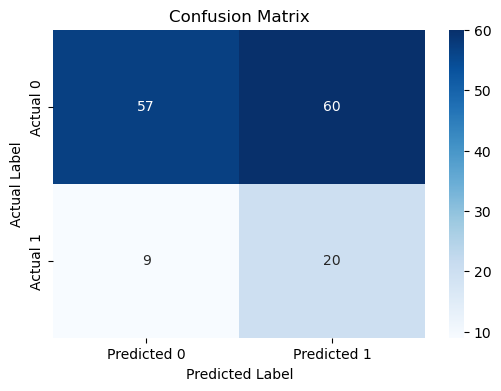

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.49      0.62       117
           1       0.25      0.69      0.37        29

    accuracy                           0.53       146
   macro avg       0.56      0.59      0.49       146
weighted avg       0.74      0.53      0.57       146



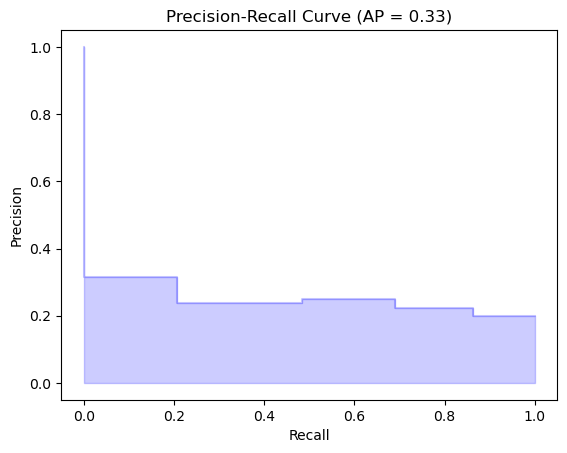

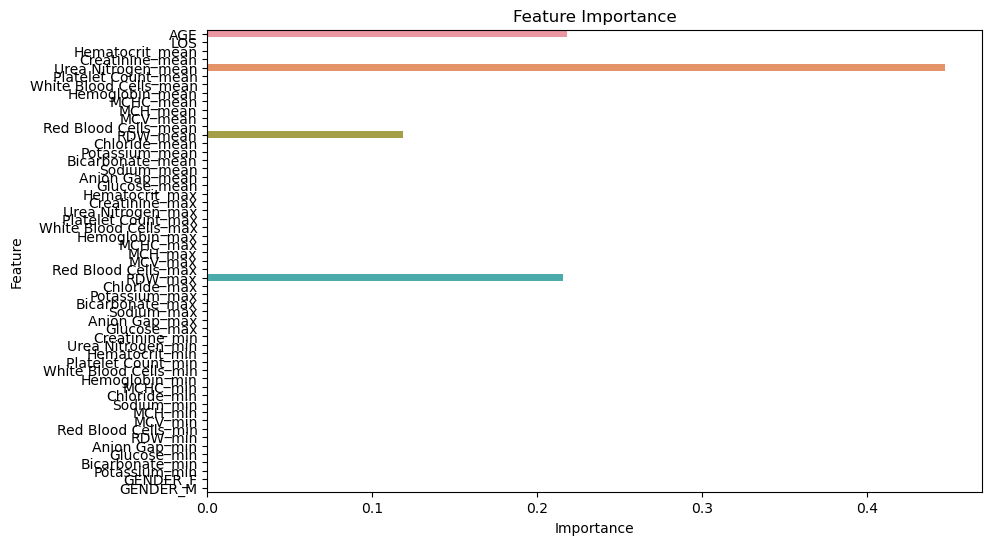

In [24]:
# Test 데이터로 모델 평가
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(test_data['y'], y_pred)
precision = precision_score(test_data['y'], y_pred)
recall = recall_score(test_data['y'], y_pred)
f1 = f1_score(test_data['y'], y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Confusion Matrix 계산
cm = confusion_matrix(test_data['y'], y_pred)

# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Classification Report 출력
print("Classification Report:")
print(classification_report(test_data['y'], y_pred))

# Precision-Recall Curve 계산 및 시각화
precision, recall, _ = precision_recall_curve(test_data['y'], best_model.predict_proba(X_test)[:, 1])
average_precision = auc(recall, precision)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()

# Feature Importance 계산
feature_importance = best_model.feature_importances_

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()